In [2]:
import pandas as pd
import numpy as np
import calculate_cleavage_rate as clv
%matplotlib inline 
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()
reload(clv)
import sys
import Nucleaseq_data_processing as processing
reload(processing)
import read_model_ID as model
reload(model)
guide = 20

sys.path.append('Toy_model')
import read_model_ID_toy as model_toy
import calculate_cleavage_rate_toy as clv_toy
reload(clv_toy)

<module 'calculate_cleavage_rate_toy' from 'Toy_model\calculate_cleavage_rate_toy.pyc'>

## Full model

PAM: 2.73766502381
From solution: -3.0662109833599995
Internal: 2.80705381635
Cleavage: 0.378917952653


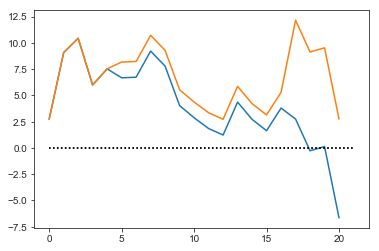

In [97]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'

filename = 'fit_18_7_2019_sim_17.txt'
path = '../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

#filename = 'fit_8_8_2019_sim_3.txt'
#path = '../fits_Stijn/8_8_2019/'
#data = pd.read_table(path+filename,index_col=False)
#chi = data.loc[:,'Potential']
#final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
#final_par_np = np.array(final_par.values)


model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
_,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)

plt.plot(range(0,21), -np.cumsum(np.append(-energies[0],energies[1:21])))
plt.plot([0,21],[0,0],'k:')

final_par_np[5] -= 1.5
final_par_np[17] -= 7.9

#final_par_np[1:21] = 0.2

model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
_,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)

plt.plot(range(0,21), -np.cumsum(np.append(-energies[0],energies[1:21])))
plt.plot([0,21],[0,0],'k:')

print 'PAM: ' + str(energies[0])
print 'From solution: ' + str(parameters_on[-2])
print 'Internal: ' + str(parameters_on[-1])
print 'Cleavage: ' + str(parameters_clv[-1])

## Coarse Graining

Energies:  2.73766502381 0.00800462297059834 -0.01154498881899979
Forward rate 1:  -1.0556991693262545
Forward rate 2:  -1.6391373445653632

Backward rates directly from forward rates
Backward rate 1:  -1.0591755329121015
Backward rate 2:  -1.6341234196276369

Backward rates from coarse graining the full model
Backward rate 1:  -1.3025651119153978
Backward rate 2:  -1.3337814512962145

Forward rates from coarse grained backward rates
Forward rate 1:  -1.299088748329551
Forward rate 2:  -1.3387953762339408


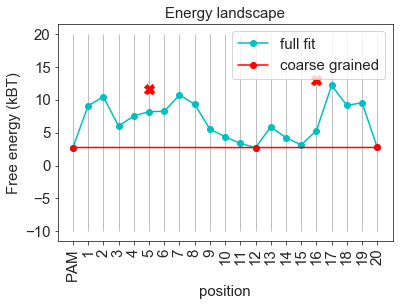

In [98]:
energies20 = energies.copy()

## Mismatch
mismatch = []
for i in mismatch:
    energies20[i] -= energies20[i+20]

## energies20
landscape = -np.cumsum(np.append(-energies20[0],energies20[1:21]))
PAM = landscape[0]
I = np.min(landscape[8:14])
Istate = np.argmin(landscape[8:14]) + 8 #position of stable I state
R = landscape[-1]

eps1 = PAM - I
eps2 = I - R

print 'Energies: ',PAM, eps1, eps2
## Getting matrix for barrier 1
rates1 = rates[1:(Istate+1)]
energies201 = -1*energies20[1:(Istate+1)]
backward1 = clv.get_backward_rates(energies201,rates1,Istate-2)
matrix1 = clv.build_rate_matrix(rates1,backward1)

backward1 = clv.get_backward_rates(-1*energies20,rates,20)[2:(Istate+2)]
backward1 = np.flip(backward1)
forward1 = np.zeros(len(backward1))
forward1[1:] = rates[-2]

matrix_back1 = clv.build_rate_matrix(backward1,forward1)

## Getting MFPT for barrier 1
matrix1 *= -1
Minv = np.linalg.inv(matrix1)
vec = np.ones(len(Minv))
everything_atPAM = np.array([1.0] + [0.0]*(Istate-1))
MFPT = vec.dot(Minv.dot(everything_atPAM))
k1 = 1/MFPT

matrix_back1 *= -1
Minv = np.linalg.inv(matrix_back1)
vec = np.ones(len(Minv))
everything_atPAM = np.array([1.0] + [0.0]*(Istate-1))
MFPT = vec.dot(Minv.dot(everything_atPAM))
kb1 = 1/MFPT

print 'Forward rate 1: ',np.log10(k1)


## Getting matrix for barrier 2
rates2 = rates[(Istate+1):-1]
energies202 = -1*energies20[(Istate+1):-1]
backward2 = clv.get_backward_rates(energies202,rates2,20-Istate-2)
matrix2 = clv.build_rate_matrix(rates2,backward2)

backward2 = clv.get_backward_rates(-1*energies20,rates,20)[(Istate+2):]
backward2 = np.flip(backward2)
forward2 = np.zeros(len(backward2))
forward2[1:] = rates[-2]
matrix_back2 = clv.build_rate_matrix(backward2,forward2)

## Getting MFPT for barrier 2
matrix2 *= -1
Minv = np.linalg.inv(matrix2)
vec = np.ones(len(Minv))
everything_atPAM = np.array([1.0] + [0.0]*(20-Istate-1))
MFPT = vec.dot(Minv.dot(everything_atPAM))
k2 = 1/MFPT

matrix_back2 *= -1
Minv = np.linalg.inv(matrix_back2)
vec = np.ones(len(Minv))
everything_atPAM = np.array([1.0] + [0.0]*(20-Istate-1))
MFPT = vec.dot(Minv.dot(everything_atPAM))
kb2 = 1/MFPT

print 'Forward rate 2: ',np.log10(k2)

parameters_CG = np.append([PAM,eps1,eps2],np.append(mismatch,[np.log10(rates[0]),np.log10(k1),np.log10(k2),np.log10(rates_clv[-1])]))


c = 4.75
parameters_CG_on = parameters_CG.copy()
parameters_CG_on[0] = parameters_CG_on[0] - np.log(c)
parameters_CG_on[-4] = parameters_CG_on[-4] + np.log10(c)

barrier1 = -np.log(k1/rates[1])
barrier2 = -np.log(k2/rates[1])
landscape4 = -np.cumsum([-PAM,eps1,eps2])
landscape20 = -np.cumsum(np.append(-energies20[0],energies20[1:21]))

plt.figure()
plot5, = plt.plot(range(0,21),landscape20,'c-o',label='full fit')
plot1, = plt.plot([0,Istate,20],landscape4,'r-o',label='coarse grained')
plt.plot([5,16],[barrier1+landscape4[0],barrier2+landscape4[1]],'rX',markersize=10)
plt.legend(handles=[plot5,plot1],fontsize=15)
plt.xlabel('position',fontsize=15)
plt.ylabel('Free energy (kBT)',fontsize=15)
plt.title('Energy landscape',fontsize=15)
if len(mismatch) > 0:
    plt.title('Energy landscape, mismatches at: ' + str(mismatch),fontsize=15)
plt.vlines(range(0,21),-10,20,color='grey',linewidth=0.5);
plt.xticks(range(0,21),['PAM'] + range(1,21),fontsize=15,rotation='vertical');
plt.yticks(fontsize=15);

kb1_ez = np.exp(-eps1)*k1
kb2_ez = np.exp(-eps2)*k2
k1_ez = np.exp(eps1)*kb1
k2_ez = np.exp(eps2)*kb2

print ''
print 'Backward rates directly from forward rates'
print 'Backward rate 1: ', np.log10(kb1_ez)
print 'Backward rate 2: ', np.log10(kb2_ez)

print ''
print 'Backward rates from coarse graining the full model'
print 'Backward rate 1: ', np.log10(kb1)
print 'Backward rate 2: ', np.log10(kb2)

print ''
print 'Forward rates from coarse grained backward rates'
print 'Forward rate 1: ', np.log10(k1_ez)
print 'Forward rate 2: ', np.log10(k2_ez)

OT-ABA: [2.55443113]


Text(453.236,0.5,'mismatch 2')

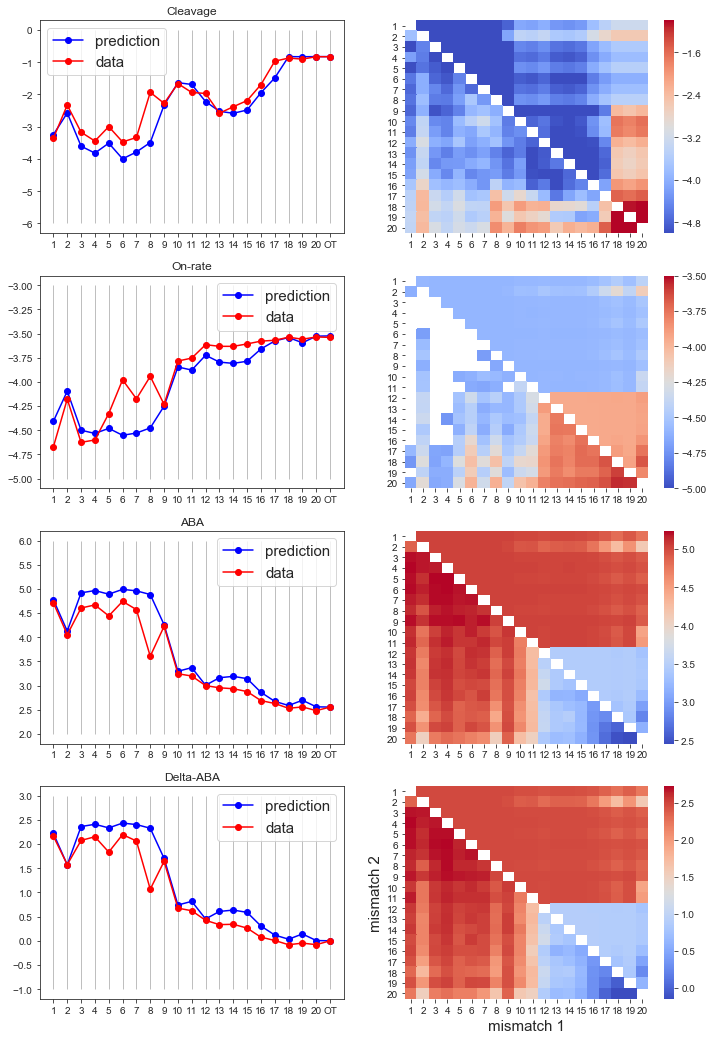

In [204]:
model_id = 'four_state_model_clv_rates+four_state_model_on_rates'; parnum = '27'

conc = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])
ref = 10. # in nanomolair
_,otaba = clv_toy.calc_clv_aba(parameters_CG,model_id,[],conc,ref)
print 'OT-ABA: ' + str(otaba)

k = np.zeros(21)
on = np.zeros(21)
for i in range(1,21):
    mismatch_positions = [i]
    k[i-1],on[i-1] = np.log10(clv_toy.calc_clv_on(parameters_CG_on,model_id,mismatch_positions))
k[-1],on[-1] = np.log10(clv_toy.calc_clv_on(parameters_CG_on,model_id,[]))

abafit = np.zeros(21)
dabafit = np.zeros(21)
for i in range(1,21):
    mismatch_positions = [i]
    _,abafit[i-1] = clv_toy.calc_clv_aba(parameters_CG,model_id,mismatch_positions,conc,ref)
    dabafit[i-1] = abafit[i-1] - otaba
abafit[-1] = otaba
dabafit[-1] = 0.

f,ax = plt.subplots(4,2,sharey=False,figsize=[12,18])
    
ax[0][0].plot(range(1,22),k,marker='o',color='blue')
ax[0][0].set_xticks(range(1,22));
ax[0][0].set_xticklabels(range(1,21)+['OT'])
ax[0][0].vlines(range(1,22),-6,0,linewidth=0.5,color='grey')
ax[0][0].plot(range(1,22),kclv,marker='o',color='red')
ax[0][0].legend(['prediction','data'],fontsize=15)
ax[0][0].set_title('Cleavage')

ax[1][0].plot(range(1,22),on,marker='o',color='blue')
#ax[1][0].errorbar(range(1,22),kon,erron*10,marker='o',color='red')
ax[1][0].set_xticks(range(1,22));
ax[1][0].set_xticklabels(range(1,21)+['OT'])
ax[1][0].vlines(range(1,22),-5,-3,linewidth=0.5,color='grey')
ax[1][0].plot(range(1,22),kon,marker='o',color='red')
ax[1][0].legend(['prediction','data'],fontsize=15)
ax[1][0].set_title('On-rate')
for i in range(21):
    if i+1==6 or i+1==7:
        ax[0][1].plot(i+1,kon[i],marker='X',color='k',markersize=10)

k_double = np.zeros([20,20])
on_double = np.zeros([20,20])
for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        k_double[i-1][j-1],on_double[i-1][j-1] = np.log10(clv_toy.calc_clv_on(parameters_CG_on,model_id,mismatch_positions))
        
k_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1, 21))
k_df = k_df + k_double_df
for i in range(1,21):
    k_df[i].loc[i]=np.nan
    
on_df = pd.DataFrame(on_double, index=range(1, 21), columns=range(1, 21))
on_df = on_df + on_double_df
for i in range(1,21):
    on_df[i].loc[i]=np.nan
    
    
aba_double = np.zeros([20,20])
daba_double = np.zeros([20,20])
for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        _,aba_double[i-1][j-1] = clv_toy.calc_clv_aba(parameters_CG,model_id,mismatch_positions,conc,ref)
        daba_double[i-1][j-1] = aba_double[i-1][j-1] - otaba
        
aba_df = pd.DataFrame(aba_double, index=range(1, 21), columns=range(1, 21))
aba_df = aba_df + aba_double_df
for i in range(1,21):
    aba_df[i].loc[i]=np.nan
    
daba_df = pd.DataFrame(daba_double, index=range(1, 21), columns=range(1, 21))
daba_df = daba_df + daba_double_df
for i in range(1,21):
    daba_df[i].loc[i]=np.nan
    
sns.heatmap(k_df, cmap='coolwarm', cbar=True,ax=ax[0][1],vmin=-5,vmax=-1)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)

sns.heatmap(on_df, cmap='coolwarm', cbar=True,ax=ax[1][1],vmin=-5,vmax=-3.5)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)



ax[2][0].plot(range(1,22),abafit,marker='o',color='blue')
ax[2][0].set_xticks(range(1,22));
ax[2][0].set_xticklabels(range(1,21)+['OT'])
ax[2][0].vlines(range(1,22),2,6,linewidth=0.5,color='grey')
ax[2][0].plot(range(1,22),aba,marker='o',color='red')
ax[2][0].legend(['prediction','data'],fontsize=15)
ax[2][0].set_title('ABA')

ax[3][0].plot(range(1,22),dabafit,marker='o',color='blue')
#ax[3][0].errorbar(range(1,22),kon,erron*10,marker='o',color='red')
ax[3][0].set_xticks(range(1,22));
ax[3][0].set_xticklabels(range(1,21)+['OT'])
ax[3][0].vlines(range(1,22),-1,3,linewidth=0.5,color='grey')
ax[3][0].plot(range(1,22),daba,marker='o',color='red')
ax[3][0].legend(['prediction','data'],fontsize=15)
ax[3][0].set_title('Delta-ABA')

sns.heatmap(aba_df, cmap='coolwarm', cbar=True,ax=ax[2][1])#,vmin=2,vmax=6)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)

sns.heatmap(daba_df, cmap='coolwarm', cbar=True,ax=ax[3][1])#,vmin=-1,vmax=3)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)

## Coarse graining all fits, and comparing rates

38
3


Text(0,0.5,'shortcut method')

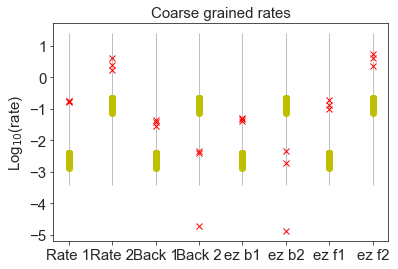

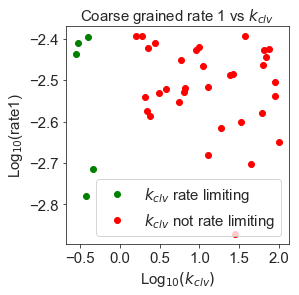

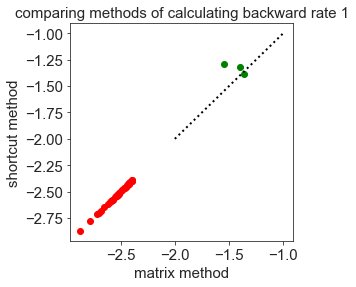

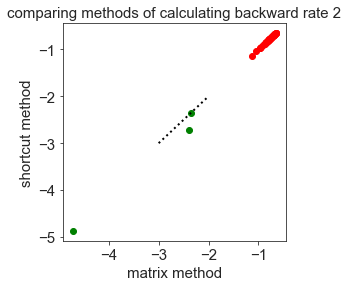

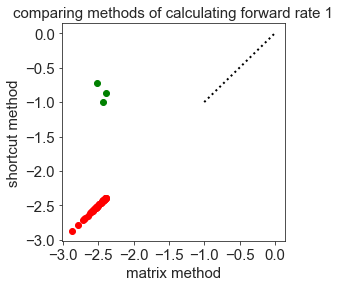

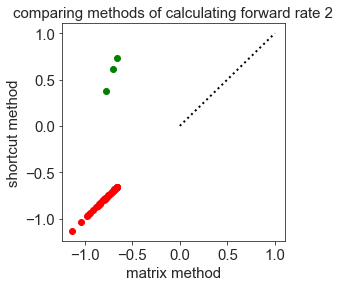

In [89]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'
parameter_list = []
backward_list1 = []

mismatch = []
for i in range(1,51):
    filename = 'fit_18_7_2019_sim_' + str(i) + '.txt'
    path = '../fits_Stijn/18_7_2019/'
    data = pd.read_table(path+filename,index_col=False)
    chi = data.loc[:,'Potential']
    final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
    final_par_np = np.array(final_par.values)
    
    final_par_np[1:7] = -2.
    final_par_np[7:13] = 2.
    final_par_np[13:17] = -2.
    final_par_np[17:21] = 2.
    
    if np.min(chi)<295.:

        model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
        energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
        _,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)
        
        ## Mismatch
        
        for i in mismatch:
            energies[i] -= energies[i+20]
        
        ## Energies
        landscape = -np.cumsum(np.append(-energies[0],energies[1:21]))
        PAM = landscape[0]
        I = np.min(landscape[8:14])
        Istate = np.argmin(landscape[8:14]) + 8
        R = landscape[-1]
        eps1 = PAM - I
        eps2 = I - R


        ## Getting matrix for barrier 1
        rates1 = rates[1:(Istate+1)]
        energies1 = -1*energies[1:(Istate+1)]
        backward1 = clv.get_backward_rates(energies1,rates1,Istate-2)
        matrix1 = clv.build_rate_matrix(rates1,backward1)
        
        backward1 = clv.get_backward_rates(-1*energies,rates,20)[2:(Istate+2)]
        backward1 = np.flip(backward1)
        forward1 = np.zeros(len(backward1))
        forward1[1:] = rates[-2]
        matrix_back1 = clv.build_rate_matrix(backward1,forward1)

        ## Getting MFPT for barrier 1
        matrix1 *= -1
        Minv = np.linalg.inv(matrix1)
        vec = np.ones(len(Minv))
        everything_atPAM = np.array([1.0] + [0.0]*(Istate-1))
        MFPT = vec.dot(Minv.dot(everything_atPAM))
        k1 = 1/MFPT
        kb1_ez = np.exp(-eps1)*k1
        
        matrix_back1 *= -1
        Minv = np.linalg.inv(matrix_back1)
        vec = np.ones(len(Minv))
        everything_atPAM = np.array([1.0] + [0.0]*(Istate-1))
        MFPT = vec.dot(Minv.dot(everything_atPAM))
        kb1 = 1/MFPT
        k1_ez = np.exp(eps1)*kb1


        ## Getting matrix for barrier 2
        rates2 = rates[(Istate+1):-1]
        energies2 = -1*energies[(Istate+1):-1]
        backward2 = clv.get_backward_rates(energies2,rates2,20-Istate-2)
        matrix2 = clv.build_rate_matrix(rates2,backward2)
        
        backward2 = clv.get_backward_rates(-1*energies,rates,20)[(Istate+2):]
        backward2 = np.flip(backward2)
        forward2 = np.zeros(len(backward2))
        forward2[1:] = rates[-2]
        matrix_back2 = clv.build_rate_matrix(backward2,forward2)

        ## Getting MFPT for barrier 2
        matrix2 *= -1
        Minv = np.linalg.inv(matrix2)
        vec = np.ones(len(Minv))
        everything_atPAM = np.array([1.0] + [0.0]*(20-Istate-1))
        MFPT = vec.dot(Minv.dot(everything_atPAM))
        k2 = 1/MFPT
        kb2_ez = np.exp(-eps2)*k2
        
        matrix_back2 *= -1
        Minv = np.linalg.inv(matrix_back2)
        vec = np.ones(len(Minv))
        everything_atPAM = np.array([1.0] + [0.0]*(20-Istate-1))
        MFPT = vec.dot(Minv.dot(everything_atPAM))
        kb2 = 1/MFPT
        k2_ez = np.exp(eps2)*kb2


        parameters_CG = np.append([PAM,eps1,eps2],np.append(mismatch,[np.log10(rates[0]),np.log10(k1),np.log10(k2),np.log10(rates_clv[-1])]))
        parameter_list.append(parameters_CG)
        
        backward1_temp = [np.log10(kb1),np.log10(kb2),np.log10(kb1_ez),np.log10(kb2_ez),np.log10(k1_ez),np.log10(k2_ez)]
        backward_list1.append(backward1_temp)
print len(parameter_list)

parameter_list2 = []
backward_list2 = []
for i in range(1,6):
    filename = 'fit_8_8_2019_sim_' + str(i) + '.txt'
    path = '../fits_Stijn/8_8_2019/'
    data = pd.read_table(path+filename,index_col=False)
    chi = data.loc[:,'Potential']
    final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
    final_par_np = np.array(final_par.values)
    
    if np.min(chi)<500.:

        model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
        energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
        _,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)
        
        ## Mismatch
        for i in mismatch:
            energies[i] -= energies[i+20]
        
        ## Energies
        landscape = -np.cumsum(np.append(-energies[0],energies[1:21]))
        PAM = landscape[0]
        I = np.min(landscape[8:14])
        Istate = np.argmin(landscape[8:14]) + 8
        R = landscape[-1]
        eps1 = PAM - I
        eps2 = I - R


        ## Getting matrix for barrier 1
        rates1 = rates[1:(Istate+1)]
        energies1 = -1*energies[1:(Istate+1)]
        backward1 = clv.get_backward_rates(energies1,rates1,Istate-2)
        matrix1 = clv.build_rate_matrix(rates1,backward1)
        
        backward1 = clv.get_backward_rates(-1*energies,rates,20)[2:(Istate+2)]
        backward1 = np.flip(backward1)
        forward1 = np.zeros(len(backward1))
        forward1[1:] = rates[-2]
        matrix_back1 = clv.build_rate_matrix(backward1,forward1)

        ## Getting MFPT for barrier 1
        matrix1 *= -1
        Minv = np.linalg.inv(matrix1)
        vec = np.ones(len(Minv))
        everything_atPAM = np.array([1.0] + [0.0]*(Istate-1))
        MFPT = vec.dot(Minv.dot(everything_atPAM))
        k1 = 1/MFPT
        kb1_ez = np.exp(-eps1)*k1
        
        matrix_back1 *= -1
        Minv = np.linalg.inv(matrix_back1)
        vec = np.ones(len(Minv))
        everything_atPAM = np.array([1.0] + [0.0]*(Istate-1))
        MFPT = vec.dot(Minv.dot(everything_atPAM))
        kb1 = 1/MFPT
        k1_ez = np.exp(eps1)*kb1


        ## Getting matrix for barrier 2
        rates2 = rates[(Istate+1):-1]
        energies2 = -1*energies[(Istate+1):-1]
        backward2 = clv.get_backward_rates(energies2,rates2,20-Istate-2)
        matrix2 = clv.build_rate_matrix(rates2,backward2)
        
        backward2 = clv.get_backward_rates(-1*energies,rates,20)[(Istate+2):]
        backward2 = np.flip(backward2)
        forward2 = np.zeros(len(backward2))
        forward2[1:] = rates[-2]
        matrix_back2 = clv.build_rate_matrix(backward2,forward2)

        ## Getting MFPT for barrier 2
        matrix2 *= -1
        Minv = np.linalg.inv(matrix2)
        vec = np.ones(len(Minv))
        everything_atPAM = np.array([1.0] + [0.0]*(20-Istate-1))
        MFPT = vec.dot(Minv.dot(everything_atPAM))
        k2 = 1/MFPT
        kb2_ez = np.exp(-eps2)*k2
        
        matrix_back2 *= -1
        Minv = np.linalg.inv(matrix_back2)
        vec = np.ones(len(Minv))
        everything_atPAM = np.array([1.0] + [0.0]*(20-Istate-1))
        MFPT = vec.dot(Minv.dot(everything_atPAM))
        kb2 = 1/MFPT
        k2_ez = np.exp(eps2)*kb2


        parameters_CG = np.append([PAM,eps1,eps2],np.append(mismatch,[np.log10(rates[0]),np.log10(k1),np.log10(k2),np.log10(rates_clv[-1])]))
        parameter_list2.append(parameters_CG)
        
        backward2_temp = [np.log10(kb1),np.log10(kb2),np.log10(kb1_ez),np.log10(kb2_ez),np.log10(k1_ez),np.log10(k2_ez)]
        backward_list2.append(backward2_temp)
print len(parameter_list2)

file = '../fits_Stijn/6_8_2019/fit_6_8_2019_sim_5.txt'
model_id = 'four_state_model_clv_rates+four_state_model_on_rates'; parnum = '27'
#model_id = 'four_state_model_clv_rates_constant_ei+four_state_model_on_rates_constant_ei_fixPAM'; parnum = '7'
#model_id = 'four_state_model_clv_rates_constant_ei+four_state_model_on_rates_constant_ei'; parnum = '8'
#model_id = 'engineered_clv_rates_constant_ei+engineered_on_rates_constant_ei'; parnum= '3'
#model_id = 'engineered_clv_rates_constant_ei_v2+engineered_on_rates_constant_ei_v2'; parnum= '4'
data = pd.read_table(file,index_col=False)
chi = data.loc[:,'Potential']
T = data.loc[:,'Temperature']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)
parameters = final_par_np


model_ID_clv,model_ID_on,parameters_clv,parameters_on = model_toy.combined_model(final_par_np,model_id)
energies_t,rates_t = model_toy.unpack_parameters(parameters_on,model_ID_on,20)
_,rates_clv = model_toy.unpack_parameters(parameters_clv,model_ID_clv,20)
rates_t[-1] = rates_clv[-1]

rates_t = np.log10(rates_t)


plt.figure(figsize = [6,4])
for i in range(len(parameter_list)):
    plot1, = plt.plot(range(1,3),parameter_list[i][-3:-1],'yo',linewidth=0,label='constrained $k_f$')
    plot3, = plt.plot(range(3,9),backward_list1[i],'yo',linewidth=0)
for i in range(len(parameter_list2)):
    plot2, = plt.plot(range(1,3),parameter_list2[i][-3:-1],'rx',linewidth=0,label='unconstrained $k_f$')
    plot4, = plt.plot(range(3,9),backward_list2[i],'rx',linewidth=0)
plt.title('Coarse grained rates',fontsize=15)
if len(mismatch) > 0:
    plt.title('Coarse grained rates, \nmismatches at: ' + str(mismatch),fontsize=15)
plt.vlines(range(1,9),-3.4,1.4,color='grey',linewidth=0.5);
plt.xticks(range(1,9),['Rate 1','Rate 2','Back 1','Back 2','ez b1','ez b2','ez f1','ez f2'],fontsize=15);
plt.ylabel('Log$_{10}$(rate)',fontsize=15)
plt.yticks(fontsize=15)
#plt.axis([0.5,2.5,-3.5,1.5])
#plt.legend(handles=[plot1,plot2],fontsize=15)

    
plt.figure(figsize=[4,4])
for i in range(len(parameter_list)):
    if parameter_list[i][-1]<0.:
        plot1, = plt.plot(parameter_list[i][-1],parameter_list[i][-3],'go',linewidth=0,label='$k_{clv}$ rate limiting')
    if parameter_list[i][-1]>0.:
        plot2, = plt.plot(parameter_list[i][-1],parameter_list[i][-3],'ro',linewidth=0,label='$k_{clv}$ not rate limiting')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Coarse grained rate 1 vs $k_{clv}$',fontsize=15)
plt.xlabel('Log$_{10}(k_{clv})$',fontsize=15)
plt.ylabel('Log$_{10}$(rate1)',fontsize=15)
plt.legend(handles=[plot1,plot2],fontsize=15)

plt.figure(figsize=[4,4])
for i in range(len(backward_list1)):
    plot1, = plt.plot(backward_list1[i][0],backward_list1[i][2],'ro',linewidth=0)
for i in range(len(backward_list2)):
    plot1, = plt.plot(backward_list2[i][0],backward_list2[i][2],'go',linewidth=0)
plt.plot([-2,-1],[-2,-1],'k:',linewidth=2.)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('comparing methods of calculating backward rate 1',fontsize=15)
plt.xlabel('matrix method',fontsize=15)
plt.ylabel('shortcut method',fontsize=15)

plt.figure(figsize=[4,4])
for i in range(len(backward_list1)):
    plot1, = plt.plot(backward_list1[i][1],backward_list1[i][3],'ro',linewidth=0)
for i in range(len(backward_list2)):
    plot1, = plt.plot(backward_list2[i][1],backward_list2[i][3],'go',linewidth=0)
plt.plot([-3,-2],[-3,-2],'k:',linewidth=2.)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('comparing methods of calculating backward rate 2',fontsize=15)
plt.xlabel('matrix method',fontsize=15)
plt.ylabel('shortcut method',fontsize=15)

plt.figure(figsize=[4,4])
for i in range(len(backward_list1)):
    plot1, = plt.plot(parameter_list[i][-3],backward_list1[i][4],'ro',linewidth=0)
for i in range(len(backward_list2)):
    plot1, = plt.plot(parameter_list[i][-3],backward_list2[i][4],'go',linewidth=0)
plt.plot([-1,0],[-1,0],'k:',linewidth=2.)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('comparing methods of calculating forward rate 1',fontsize=15)
plt.xlabel('matrix method',fontsize=15)
plt.ylabel('shortcut method',fontsize=15)

plt.figure(figsize=[4,4])
for i in range(len(backward_list1)):
    plot1, = plt.plot(parameter_list[i][-2],backward_list1[i][5],'ro',linewidth=0)
for i in range(len(backward_list2)):
    plot1, = plt.plot(parameter_list[i][-2],backward_list2[i][5],'go',linewidth=0)
plt.plot([0,1],[0,1],'k:',linewidth=2.)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('comparing methods of calculating forward rate 2',fontsize=15)
plt.xlabel('matrix method',fontsize=15)
plt.ylabel('shortcut method',fontsize=15)

## Predicting using coarse grained rates

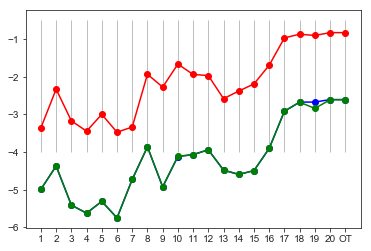

In [90]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'

filename = 'fit_18_7_2019_sim_17.txt'
path = '../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

final_par_np[1:7] = -2.
final_par_np[7:13] = 2.
final_par_np[13:17] = -2.
final_par_np[17:21] = 2.

model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
_,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)


kclv_coarse = []
kclv_coarseez = []
for i in range(1,21):
    energies20 = energies.copy()

    ## Mismatch
    mismatch = [i]
    for i in mismatch:
        energies20[i] -= energies20[i+20]

    ## energies20
    landscape = -np.cumsum(np.append(-energies20[0],energies20[1:21]))
    PAM = landscape[0]
    I = np.min(landscape[8:14])
    Istate = np.argmin(landscape[8:14]) + 8 #position of stable I state
    R = landscape[-1]

    eps1 = PAM - I
    eps2 = I - R

    ## Getting matrix for barrier 1
    rates1 = rates[1:(Istate+1)]
    energies201 = -1*energies20[1:(Istate+1)]
    backward1 = clv.get_backward_rates(energies201,rates1,Istate-2)
    matrix1 = clv.build_rate_matrix(rates1,backward1)

    backward1 = clv.get_backward_rates(-1*energies20,rates,20)[2:(Istate+2)]
    backward1 = np.flip(backward1)
    forward1 = np.zeros(len(backward1))
    forward1[1:] = rates[-2]
    matrix_back1 = clv.build_rate_matrix(backward1,forward1)

    ## Getting MFPT for barrier 1
    matrix1 *= -1
    Minv = np.linalg.inv(matrix1)
    vec = np.ones(len(Minv))
    everything_atPAM = np.array([1.0] + [0.0]*(Istate-1))
    MFPT = vec.dot(Minv.dot(everything_atPAM))
    k1 = 1/MFPT

    matrix_back1 *= -1
    Minv = np.linalg.inv(matrix_back1)
    vec = np.ones(len(Minv))
    everything_atPAM = np.array([1.0] + [0.0]*(Istate-1))
    MFPT = vec.dot(Minv.dot(everything_atPAM))
    kb1 = 1/MFPT
    kb1ez = k1*np.exp(-eps1)

    ## Getting matrix for barrier 2
    rates2 = rates[(Istate+1):-1]
    energies202 = -1*energies20[(Istate+1):-1]
    backward2 = clv.get_backward_rates(energies202,rates2,20-Istate-2)
    matrix2 = clv.build_rate_matrix(rates2,backward2)

    backward2 = clv.get_backward_rates(-1*energies20,rates,20)[(Istate+2):]
    backward2 = np.flip(backward2)
    forward2 = np.zeros(len(backward2))
    forward2[1:] = rates[-2]
    matrix_back2 = clv.build_rate_matrix(backward2,forward2)

    ## Getting MFPT for barrier 2
    matrix2 *= -1
    Minv = np.linalg.inv(matrix2)
    vec = np.ones(len(Minv))
    everything_atPAM = np.array([1.0] + [0.0]*(20-Istate-1))
    MFPT = vec.dot(Minv.dot(everything_atPAM))
    k2 = 1/MFPT

    matrix_back2 *= -1
    Minv = np.linalg.inv(matrix_back2)
    vec = np.ones(len(Minv))
    everything_atPAM = np.array([1.0] + [0.0]*(20-Istate-1))
    MFPT = vec.dot(Minv.dot(everything_atPAM))
    kb2 = 1/MFPT
    kb2ez = k2*np.exp(-eps2)

    forward_rates = np.array([1000,k1,k2,rates_clv[-1]])
    backward_rates = np.array([0.,1000*np.exp(-100),kb1,kb2])
    backward_ratesez = np.array([0.,1000*np.exp(-100),kb1ez,kb2ez])
    matrix_coarse = clv.build_rate_matrix(forward_rates,backward_rates)
    matrix_coarse *= -1
    Minv = np.linalg.inv(matrix_coarse)
    vec = np.ones(len(Minv))
    everything_atPAM = np.array([1.0] + [0.0]*(3))
    MFPT = vec.dot(Minv.dot(everything_atPAM))
    k_coarse = 1/MFPT
    
    matrix_coarse = clv.build_rate_matrix(forward_rates,backward_ratesez)
    matrix_coarse *= -1
    Minv = np.linalg.inv(matrix_coarse)
    vec = np.ones(len(Minv))
    everything_atPAM = np.array([1.0] + [0.0]*(3))
    MFPT = vec.dot(Minv.dot(everything_atPAM))
    k_coarseez = 1/MFPT
    
    kclv_coarse.append(np.log10(k_coarse))
    kclv_coarseez.append(np.log10(k_coarseez))
    
energies20 = energies.copy()

## Mismatch
mismatch = [i]
for i in mismatch:
    energies20[i] -= energies20[i+20]

## energies20
landscape = -np.cumsum(np.append(-energies20[0],energies20[1:21]))
PAM = landscape[0]
I = np.min(landscape[9:14])
Istate = np.argmin(landscape[9:14]) + 9 #position of stable I state
R = landscape[-1]

eps1 = PAM - I
eps2 = I - R

## Getting matrix for barrier 1
rates1 = rates[1:(Istate+1)]
energies201 = -1*energies20[1:(Istate+1)]
backward1 = clv.get_backward_rates(energies201,rates1,Istate-2)
matrix1 = clv.build_rate_matrix(rates1,backward1)

backward1 = clv.get_backward_rates(-1*energies20,rates,20)[2:(Istate+2)]
backward1 = np.flip(backward1)
forward1 = np.zeros(len(backward1))
forward1[1:] = rates[-2]
matrix_back1 = clv.build_rate_matrix(backward1,forward1)

## Getting MFPT for barrier 1
matrix1 *= -1
Minv = np.linalg.inv(matrix1)
vec = np.ones(len(Minv))
everything_atPAM = np.array([1.0] + [0.0]*(Istate-1))
MFPT = vec.dot(Minv.dot(everything_atPAM))
k1 = 1/MFPT

matrix_back1 *= -1
Minv = np.linalg.inv(matrix_back1)
vec = np.ones(len(Minv))
everything_atPAM = np.array([1.0] + [0.0]*(Istate-1))
MFPT = vec.dot(Minv.dot(everything_atPAM))
kb1 = 1/MFPT
kb1ez = k1*np.exp(-eps1)

## Getting matrix for barrier 2
rates2 = rates[(Istate+1):-1]
energies202 = -1*energies20[(Istate+1):-1]
backward2 = clv.get_backward_rates(energies202,rates2,20-Istate-2)
matrix2 = clv.build_rate_matrix(rates2,backward2)

backward2 = clv.get_backward_rates(-1*energies20,rates,20)[(Istate+2):]
backward2 = np.flip(backward2)
forward2 = np.zeros(len(backward2))
forward2[1:] = rates[-2]
matrix_back2 = clv.build_rate_matrix(backward2,forward2)

## Getting MFPT for barrier 2
matrix2 *= -1
Minv = np.linalg.inv(matrix2)
vec = np.ones(len(Minv))
everything_atPAM = np.array([1.0] + [0.0]*(20-Istate-1))
MFPT = vec.dot(Minv.dot(everything_atPAM))
k2 = 1/MFPT

matrix_back2 *= -1
Minv = np.linalg.inv(matrix_back2)
vec = np.ones(len(Minv))
everything_atPAM = np.array([1.0] + [0.0]*(20-Istate-1))
MFPT = vec.dot(Minv.dot(everything_atPAM))
kb2 = 1/MFPT
kb2ez = k2*np.exp(-eps2)

forward_rates = np.array([1000,k1,k2,rates_clv[-1]])
backward_rates = np.array([0.,1000*np.exp(-100),kb1,kb2])
backward_ratesez = np.array([0.,1000*np.exp(-100),kb1ez,kb2ez])
matrix_coarse = clv.build_rate_matrix(forward_rates,backward_rates)
matrix_coarse *= -1
Minv = np.linalg.inv(matrix_coarse)
vec = np.ones(len(Minv))
everything_atPAM = np.array([1.0] + [0.0]*(3))
MFPT = vec.dot(Minv.dot(everything_atPAM))
k_coarse = 1/MFPT

matrix_coarse = clv.build_rate_matrix(forward_rates,backward_ratesez)
matrix_coarse *= -1
Minv = np.linalg.inv(matrix_coarse)
vec = np.ones(len(Minv))
everything_atPAM = np.array([1.0] + [0.0]*(3))
MFPT = vec.dot(Minv.dot(everything_atPAM))
k_coarseez = 1/MFPT

kclv_coarse.append(np.log10(k_coarse))
kclv_coarseez.append(np.log10(k_coarseez))

plt.plot(range(1,22),kclv,color='r',marker='o')
plt.plot(range(1,22),kclv_coarse,color='b',marker='o')
plt.plot(range(1,22),kclv_coarseez,color='g',marker='o')
plt.vlines(range(1,22),-4,-0.5,color='grey',linewidth=0.5)
plt.xticks(range(1,22),range(1,21)+['OT']);



## Load Data

In [14]:
filename = 'WT_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
path_to_data = '../data_nucleaseq_Finkelsteinlab/targetE/'

xdata, ydata, yerr = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data,True,False,True)
_, ydatafull, yerrfull = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data,False)

filename_daba = 'cas9-target-e-replicate-1-delta-abas_Canonical_OT-r_0-20.csv'
path_to_data_daba = '../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'

filename_aba = 'TargetE-dCas9_AbsoluteABA_Canonical_OT-r_0-2.csv'
path_to_data_aba = '../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'

_, ydata_daba, yerr_daba = processing.prepare_multiprocessing_combined_delta_aba(filename_daba,filename,path_to_data_daba,path_to_data,False)
_, ydatawa_daba, yerrwa_daba = processing.prepare_multiprocessing_combined_delta_aba(filename_daba,filename,path_to_data_daba,path_to_data,True)

_, ydata_aba, yerr_aba = processing.prepare_multiprocessing_combined_aba(filename_aba,filename,path_to_data_aba,path_to_data,False)
_, ydatawa_aba, yerrwa_aba = processing.prepare_multiprocessing_combined_aba(filename_aba,filename,path_to_data_aba,path_to_data,True)

kclv = []
kon = []
erron = []
aba = []
daba = []
i = 1
while i < 20+1:
    for a in range(len(xdata)):
        if len(xdata[a])==1 and xdata[a][0]==i:
            kclv.append(ydata[a][0][0])
            kon.append((ydata[a][1][0]))
            aba.append((ydatawa_aba[a][1][0]))
            daba.append((ydatawa_daba[a][1][0]))
            erron.append((yerr[a][1][0]))
            i = i + 1
    
kclv.append(ydata[0][0][0])
kclv = np.array(kclv)
kon.append((ydata[0][1][0]))
kon = np.array(kon)
aba.append((ydatawa_aba[0][1][0]))
aba = np.array(aba)
daba.append(0.0)
daba = np.array(daba)
erron.append(yerr[0][1][0])
erron = np.array(erron)


k_double = np.zeros([20,20])
on_double = np.zeros([20,20])
aba_double = np.zeros([20,20])
daba_double = np.zeros([20,20])

for a in range(len(xdata)):
    if len(xdata[a])==2:
        i = xdata[a][0]
        j = xdata[a][1]
        k_double[j-1,i-1] = (ydata[a][0][0])
        aba_double[j-1,i-1] = ydatawa_aba[a][1][0]
        daba_double[j-1,i-1] = ydatawa_daba[a][1][0]
        if len(ydata[a][1])>0:
            on_double[j-1,i-1] = (ydata[a][1][0])
        else:
            on_double[j-1,i-1] = np.nan
        
k_double_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1, 21))
on_double_df = pd.DataFrame(on_double, index=range(1, 21), columns=range(1, 21))
aba_double_df = pd.DataFrame(aba_double, index=range(1, 21), columns=range(1, 21))
daba_double_df = pd.DataFrame(daba_double, index=range(1, 21), columns=range(1, 21))